In [1]:
import numpy as np
import torch
import seaborn
import pickle
import pandas as pd
from sklearn import metrics
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from sklearn.metrics import confusion_matrix, f1_score
import pytorch_lightning as pl

In [2]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [3]:
def xmlToDf(xmlFile):
    # Read XML file
    df = pd.read_xml(xmlFile)
    #replace None to empty string in commentaire column
    df["commentaire"] = df["commentaire"].apply(checkIfWordInComment)
    #check if not column exist
    if "note" in df.columns:
        # replace comma to point in note column
        df["note"] = df["note"].apply(lambda x: x.replace(",", "."))
        # string to double conversion column
        df['note'] = df['note'].astype(float)
        df['note'] = df['note'].apply(lambda x: x * 2 -1)
        df['note'] = df['note'].astype(int)
    return df

def checkIfWordInComment(comment):
    if comment is None:
        return ""
    return comment

df_train = xmlToDf("data/train.xml")
df_dev = xmlToDf("data/dev.xml")
df_test = xmlToDf("data/test.xml")

In [60]:
import json

# list all unique movies values
movies = df_train["movie"].unique().tolist() + df_dev["movie"].unique().tolist() + df_test["movie"].unique().tolist()

#convert all movies values to int
for i in range(len(movies)):
    movies[i] = int(movies[i])
    
# load in a df all movies with json files in movies folder
df_movies = pd.DataFrame(columns=["name", "genre", "averageRate", "director"], index=movies)
for movie in movies:
    try:
        with open("movies/" + str(movie) + ".json", encoding="utf-8") as json_file:
            data = json.load(json_file, strict=False)
            # convert ratingValue to float by replacing comma to point and then multiply by 2 minus 1
            data['aggregateRating']['ratingValue'] = float(data['aggregateRating']['ratingValue'].replace(",", ".")) * 2 - 1           
            # if key director does not exist, we put an empty string
            if 'director' not in data:
                row = {'name': data['name'], 'genre': data['genre'], 'averageRate': data['aggregateRating']['ratingValue'], 'director': ""}
            elif type(data['director']) is list:
                row = {'name': data['name'], 'genre': data['genre'], 'averageRate': data['aggregateRating']['ratingValue'], 'director': data['director'][0]['name']}
            else:
                row = {'name': data['name'], 'genre': data['genre'], 'averageRate': data['aggregateRating']['ratingValue'], 'director': data['director']['name']}       
            df_movies.loc[movie] = row
    except:
        print("Error with movie " + str(movie))
        row = {'name': " ", 'genre': " ", 'averageRate': " ", 'director': " "}
        df_movies.loc[movie] = row


#define method to add special tokens to comment of a df row by looking for information in df_movies
def addSpecialTokens(row):
    movie = row["movie"]
    genre = df_movies.loc[int(movie)]["genre"]
    rate = df_movies.loc[int(movie)]["averageRate"]
    director = df_movies.loc[int(movie)]["director"]
    name = df_movies.loc[int(movie)]["name"]
    comment = row["commentaire"]
    if type(genre) is list:
        genre = ";".join(genre)
    if type(row["name"]) is not str:
        return "<MOVIE>" + name + "<GENRE>" + genre + "<RATE>" + str(rate) + "<DIRECTOR>" + director + "<REVIEW>" + comment
    elif name == " ":
        return "<NAME>" + row["name"] + "<REVIEW>" + comment
    else:   
        return "<MOVIE>" + name + "<GENRE>" + genre + "<RATE>" + str(rate) + "<DIRECTOR>" + director + "<NAME>" + row["name"] + "<REVIEW>" + comment

#add special tokens to all comments
df_dev["commentaire_token"] = df_dev.apply(addSpecialTokens, axis=1)
df_test["commentaire_token"] = df_test.apply(addSpecialTokens, axis=1)

Error with movie 262929
Error with movie 269431
Error with movie 257053


In [61]:
comments = df_test["commentaire_token"].astype(str).values.tolist()
# for i in range(len(comments)):
#     comments[i] = " ".join(comments[i])
    
#add new column to df_test named "predict_note" initialized with 0 int if column does not exist
if "predict_note_test" not in df_dev.columns:
    df_dev["predict_note_test"] = 0

if "note" not in df_test.columns:
    df_test["note"] = 0
# TOKENIZER = CamembertTokenizer.from_pretrained(
#     'camembert/camembert-base',
#     do_lower_case=True)


tokenizer = AutoTokenizer.from_pretrained(
    'camembert/camembert-base',
    do_lower_case=True)

In [57]:
# check if None in comments
for i in range(len(comments)):
    if comments[i] is None:
        print (i)
        comments[i] = ""

In [62]:
lightning_model = LightningModel("camembert-base", 10, lr=3e-5, weight_decay=0.).cuda()

# load model state dict from file model_lightning.pt
lightning_model.model.load_state_dict(torch.load("model_lightning.pt"))


def preprocess(raw_reviews, rates=None):
    encoded_batch = tokenizer.batch_encode_plus(raw_reviews,
                                                add_special_tokens=True,
                                                padding=True,
                                                truncation=True,
                                                max_length=512,
                                                return_attention_mask = True,
                                                return_tensors = 'pt')
    return encoded_batch['input_ids'], encoded_batch['attention_mask']
 
def predict(reviews, model=lightning_model.model):
    with torch.no_grad():
        input_ids, attention_mask = preprocess(reviews)
        input_ids,attention_mask = input_ids.cuda(), attention_mask.cuda() 
        retour = model(input_ids, attention_mask=attention_mask)
        return torch.argmax(retour[0], dim=1).cuda() 
 
# function that predict the rate of a review
def predict_rate(review, model=lightning_model.model):
    return predict([review], model)

 
def evaluate(model, reviews, rates):
    predictions = predict(reviews, model).cpu()
    print(predictions)
    print(metrics.f1_score(rates.cpu(), predictions.cpu(), average='weighted', zero_division=0))
    seaborn.heatmap(metrics.confusion_matrix(rates.cpu(), predictions.cpu()))


# #loop for with tqdm to predict the rate of each review
# for i in tqdm(range(len(comments))):
#     df_test["note"][i] = predict_rate(comments[i]).item()

#loop for with tqdm to predict the rate of each review sending by batch of 8 and assign the rate to the df_test
for i in tqdm(range(len(comments)//16)):
    df_test["note"][i*16:(i+1)*16] = predict(comments[i*16:(i+1)*16]).cpu().numpy()



Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

In [33]:
#create new column in df_test named "rate" that convert the column "note" to float by replacing the "," by "."
# df_dev["rate"] = df_test["note"].str.replace(",", ".").astype(float)

# multiply all values in the column "rate" by 2 and then minus 1
# df_test["rate"] = df_test["rate"]*2-1


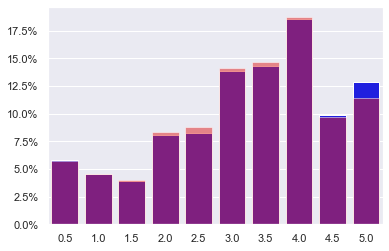

85847


In [150]:
import seaborn as sns
import matplotlib.ticker as mtick
sns.set_theme(style="darkgrid")

# create real_note column in df_dev and df_train with the values of the column "note" +1 1 and divided by 2
df_dev["real_note"] = (df_dev["note"]+1)/2
df_train["real_note"] = (df_train["note"]+1)/2

# graph of the distribution of the real notes in df_dev and df_train with seaborn to see if the distribution is
# the same in both dataframes with barplot with same color for each dataframe
# sns.barplot(x=df_train["real_note"].value_counts().index, y=df_train["real_note"].value_counts().values, color="red", alpha=0.5)
# sns.barplot(x=df_dev["real_note"].value_counts().index, y=df_dev["real_note"].value_counts().values, color="blue")

# graph of the distribution of the real notes in df_dev and df_train with seaborn to see if the distribution is
# the same in both dataframes with barplot with same color for each dataframe with Y axis as pourcentage of the total number of notes
sns.barplot(x=df_dev["real_note"].value_counts().index, y=df_dev["real_note"].value_counts().values/df_dev["real_note"].value_counts().values.sum(), color="blue")
sns.barplot(x=df_train["real_note"].value_counts().index, y=df_train["real_note"].value_counts().values/df_train["real_note"].value_counts().values.sum(), color="red", alpha=0.5)
#change the y axis to pourcentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
 
print(len(df_test))

 

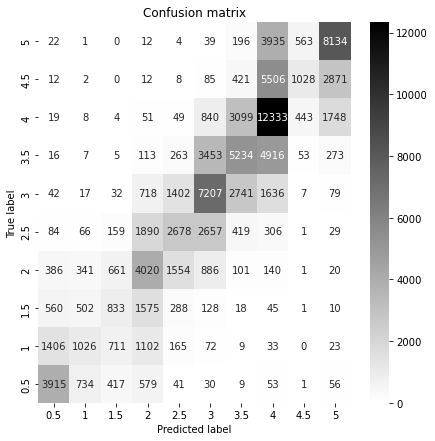

In [72]:
from matplotlib import pyplot as plt

labels = ["0.5", "1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", "5"]

# generate plot of the confusion matrix between df_test["note"] and df_test["predict_note"] with pyplot
plt.figure(figsize=(7,7))
seaborn.heatmap(metrics.confusion_matrix(df_dev["note"], df_dev["predict_note"]), annot=True, fmt="d", cmap="gray_r")
#inverse y axis
plt.gca().invert_yaxis()
#change label of x axis and y axis with labels list centered to row and column
plt.xticks(np.arange(10)+0.5, labels, ha='center')
plt.yticks(np.arange(10)+0.5, labels, va='center')
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')

#save graph in file with white background 
plt.savefig("img/confusion_matrix.png", transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()
#save graph in file


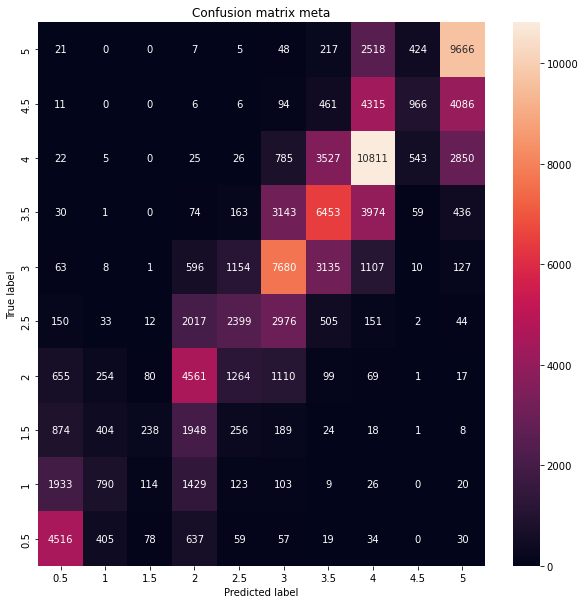

In [48]:
# generate plot of the confusion matrix between df_test["note"] and df_test["predict_note"] with pyplot
plt.figure(figsize=(10,10))
seaborn.heatmap(metrics.confusion_matrix(df_dev["note_meta"], df_dev["predict_note_meta"]), annot=True, fmt="d")
#inverse y axis
plt.gca().invert_yaxis()
#change label of x axis and y axis with labels list centered to row and column
plt.xticks(np.arange(10)+0.5, labels, ha='center')
plt.yticks(np.arange(10)+0.5, labels, va='center')
plt.title("Confusion matrix meta")
plt.ylabel('True label')
plt.xlabel('Predicted label')

#save graph in file with white background 
plt.savefig("img/confusion_matrix_meta.png", transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()
#save graph in file

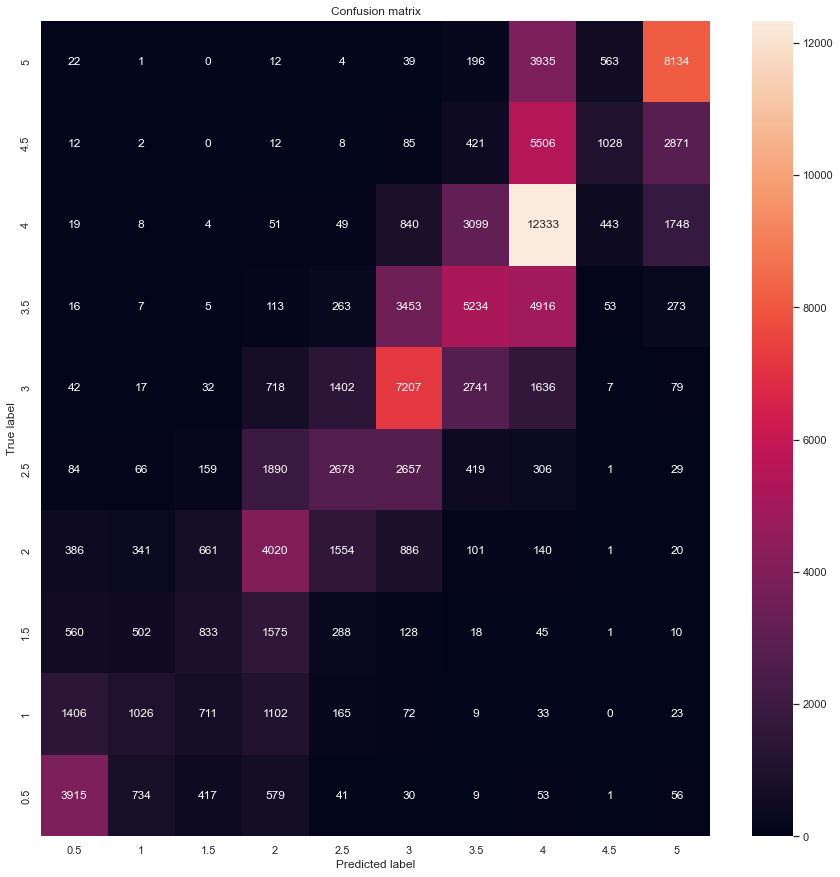

In [153]:
from matplotlib import pyplot as plt

labels = ["0.5", "1", "1.5", "2", "2.5", "3", "3.5", "4", "4.5", "5"]

# generate plot of the confusion matrix between df_test["note"] and df_test["predict_note"] with pyplot
plt.figure(figsize=(15,15))
seaborn.heatmap(metrics.confusion_matrix(df_dev["note"], df_dev["predict_note"]), annot=True, fmt="d")
#inverse y axis
plt.gca().invert_yaxis()
#change label of x axis and y axis with labels list centered to row and column
plt.xticks(np.arange(10)+0.5, labels, ha='center')
plt.yticks(np.arange(10)+0.5, labels, va='center')
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')

#save graph in file with white background 
plt.savefig("img/confusion_matrix_big.png", transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()
#save graph in file

In [63]:
#generate txt file with this format : review_id rate
# rate dot replace by comma
with open("data/df_train_meta_test.txt", "w") as f:
    for i in range(len(df_test)):
        f.write(str(df_test["review_id"][i]) + " " + str((df_test["note"][i]+1)/2).replace(".",",") + "\n")
